# MNIST WGAN with Gradient Regularization

https://www.easy-tensorflow.com/tf-tutorials/basics/save-and-restore

In [1]:
import matplotlib.pyplot as plt
import sys
import os

In [2]:
sys.path.insert(0, "src")
import models

Using TensorFlow backend.


In [3]:
import numpy as np
np.random.seed(100)

In [4]:
import tensorflow as tf
tf.set_random_seed(100)

In [5]:
from keras.utils import Progbar

## Load Data

In [6]:
from keras.datasets import mnist

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [8]:
def batch_generator(X, labels, batch_size=64):
    while True:
        choice = np.random.choice(len(X), batch_size, replace=False)
        X_batch = X[choice][..., np.newaxis]
        X_batch = X_batch / 127.5 - 1.
        y_batch = labels[choice][:, np.newaxis]
        yield X_batch, y_batch

In [9]:
test_batch, test_labels = next(batch_generator(X_train, y_train))

In [10]:
def plot_batch(batch):
    for i, img in enumerate(batch):
        plt.subplot(1, len(batch), i + 1)
        plt.imshow(0.5 * (img.squeeze() + 1.), cmap=plt.cm.gray)
        plt.axis("off")
    plt.show()

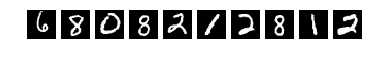

In [11]:
plot_batch(test_batch[:10])

In [12]:
test_batch.shape

(64, 28, 28, 1)

## Build Models

In [13]:
img_shape = (28,28,1)
latent_dim = 100
nb_blocks = 2
nb_filters = 64
lambda_reg = 10

In [14]:
with tf.variable_scope("discriminator"):
    D = models.DC_discriminator(img_shape, nb_blocks+2, nb_filters)

In [15]:
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
__________

In [16]:
with tf.variable_scope("generator"):
    G = models.DC_generator(img_shape, latent_dim, nb_blocks, nb_filters)

In [17]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       409728    
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 128)       0         
__________

In [18]:
d_real = tf.placeholder("float32", (None,) + img_shape)
d_fake = tf.placeholder("float32", (None,) + img_shape)
d_out_real = D(d_real)
d_reg = 0.5 * lambda_reg * tf.reduce_sum(tf.pow(tf.gradients(d_out_real, d_real), 2))
d_loss = -tf.reduce_mean(d_out_real) + tf.reduce_mean(D(d_fake)) + d_reg
d_opt = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(d_loss)

g_input = tf.placeholder('float32', (None, latent_dim))
g_out = G(g_input)
g_loss = -tf.reduce_mean(D(g_out))
g_params = tf.trainable_variables("generator")
# g_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="generator")
g_opt = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(g_loss, var_list=g_params)

In [19]:
g_params

[<tf.Variable 'generator/dense_2/kernel:0' shape=(100, 6272) dtype=float32_ref>,
 <tf.Variable 'generator/dense_2/bias:0' shape=(6272,) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_5/kernel:0' shape=(5, 5, 128, 128) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_5/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_6/kernel:0' shape=(5, 5, 128, 64) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_6/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_7/kernel:0' shape=(3, 3, 64, 1) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_7/bias:0' shape=(1,) dtype=float32_ref>]

In [20]:
# d_params = tf.trainable_variables("discriminator")
# clip_dis_var_op = [var.assign(tf.clip_by_value(var, -0.01, 0.01)) for var in d_params]

# Train Models

In [21]:
nb_epochs = 100
iter_per_epoch = 100
dis_iter = 5
batch_size = 128
log_dir = "./logs/mnist-wgan-gp"

In [22]:
generator = batch_generator(X_train, y_train, batch_size)

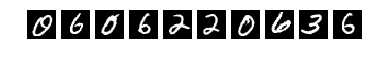

In [23]:
plot_batch(next(generator)[0][:10])

In [24]:
sw = tf.summary.FileWriter(log_dir)
def update_tb_summary(step):
    s = tf.Summary()

    # losses as is
    for name, vals in [("D_losses", d_print_log), ("G_losses", g_print_log)]:
        v = s.value.add()
        v.simple_value = vals[-1]
        v.tag = name
        
    sw.add_summary(s, step)
    sw.flush()

def save_sample_images(step):
    zz = np.random.normal(0., 1., (100, latent_dim))
    generated_images = sess.run(g_out, feed_dict={g_input : zz})
    img = np.hstack(np.hstack(generated_images.reshape((10,10) + generated_images.shape[1:])))
    img = 0.5 * (img + 1.)
    
    path = os.path.join(log_dir, "samples_%07d.png" % step)
    plt.imsave(path, img.squeeze(), cmap=plt.cm.gray)

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [26]:
D_init = D.get_weights()

In [27]:
d_print_log = []
g_print_log = []

for e in range(nb_epochs):
    print("Epoch {}/{}".format(e + 1, nb_epochs))
    progbar = Progbar(iter_per_epoch)
    
    for it in range(iter_per_epoch):
        for i in range(dis_iter):
            
#             for l in D.layers:
#                 weights = l.get_weights()
#                 weights = [np.clip(w, -0.01, 0.01) for w in weights]
#                 l.set_weights(weights)
                
            batch_zz = np.random.normal(0., 1., (batch_size, latent_dim))
            batch_real, _ = next(generator)
            batch_fake = sess.run(g_out, feed_dict={g_input : batch_zz})
            
#             sess.run(clip_dis_var_op)
            sess.run(d_opt, feed_dict={d_real : batch_real, d_fake : batch_fake})
            
        d_print_log.append(sess.run(d_loss, feed_dict={d_real : batch_real, d_fake : batch_fake}))
        
        batch_zz = np.random.normal(0., 1., (batch_size, latent_dim))
        sess.run(g_opt, feed_dict={g_input : batch_zz})
        g_print_log.append(sess.run(g_loss, feed_dict={g_input : batch_zz}))
        
        progbar.update(it + 1, values=[("D_loss", d_print_log[-1]), ("G_loss", g_print_log[-1])])
    
    step = iter_per_epoch * (e + 1)
    update_tb_summary(step)
    save_sample_images(step)

Epoch 1/100
100/100 [==============================] - 48s 482ms/step - D_loss: -0.1463 - G_loss: 0.1721
Epoch 2/100
100/100 [==============================] - 52s 523ms/step - D_loss: -0.1062 - G_loss: 0.6838
Epoch 3/100
100/100 [==============================] - 52s 524ms/step - D_loss: -0.0345 - G_loss: 0.3696
Epoch 4/100
100/100 [==============================] - 52s 518ms/step - D_loss: -0.0233 - G_loss: 0.2154
Epoch 5/100
100/100 [==============================] - 46s 465ms/step - D_loss: -0.0196 - G_loss: 0.1642
Epoch 6/100
100/100 [==============================] - 52s 515ms/step - D_loss: -0.0168 - G_loss: 0.1386
Epoch 7/100
100/100 [==============================] - 53s 525ms/step - D_loss: -0.0144 - G_loss: 0.1214
Epoch 8/100
100/100 [==============================] - 51s 514ms/step - D_loss: -0.0129 - G_loss: 0.1127
Epoch 9/100
100/100 [==============================] - 49s 488ms/step - D_loss: -0.0115 - G_loss: 0.0967
Epoch 10/100
100/100 [==============================] -

100/100 [==============================] - 50s 501ms/step - D_loss: -0.0033 - G_loss: 0.0079
Epoch 79/100
100/100 [==============================] - 50s 502ms/step - D_loss: -0.0035 - G_loss: 0.0071
Epoch 80/100
100/100 [==============================] - 50s 503ms/step - D_loss: -0.0032 - G_loss: 0.0081
Epoch 81/100
100/100 [==============================] - 50s 505ms/step - D_loss: -0.0034 - G_loss: 0.0074
Epoch 82/100
100/100 [==============================] - 50s 503ms/step - D_loss: -0.0033 - G_loss: 0.0074
Epoch 83/100
100/100 [==============================] - 49s 494ms/step - D_loss: -0.0032 - G_loss: 0.0076
Epoch 84/100
100/100 [==============================] - 44s 442ms/step - D_loss: -0.0032 - G_loss: 0.0094
Epoch 85/100
100/100 [==============================] - 47s 467ms/step - D_loss: -0.0032 - G_loss: 0.0086
Epoch 86/100
100/100 [==============================] - 51s 505ms/step - D_loss: -0.0032 - G_loss: 0.0084
Epoch 87/100
100/100 [==============================] - 50s